<a href="https://colab.research.google.com/github/Nikhileswar-Komati/Deep-Learning/blob/master/VIOLENCE_1-90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikhileswarkomati","key":"e75f0f971ce7ce2b2bc748fa02cbafd1"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset -p /content

100% 3.57G/3.58G [01:06<00:00, 34.7MB/s]
100% 3.58G/3.58G [01:06<00:00, 57.6MB/s]


In [4]:
!unzip \*.zip

Archive:  real-life-violence-situations-dataset.zip
  inflating: Real Life Violence Dataset/NonViolence/NV_1.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_10.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_100.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_1000.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_101.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_102.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_103.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_104.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_105.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_106.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_107.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_108.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_109.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_11.mp4  
  inflating: Real Life Violence Dataset/N

In [5]:
!pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp36-none-any.whl size=12883 sha256=8bbbe022518e14a65a386adfbcbea741f9eed7c87d5c7dada2d2441e24224d96
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [5]:
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = ['Violence', 'NonViolence']
classes.sort()
# some global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 8
BS = 8
# pattern to get videos and classes
glob_pattern = '/content/Real Life Violence Dataset/{classname}/*'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    rotation_range=8,
    width_shift_range=.1,
    height_shift_range=.1)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.10, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

class NonViolence, validation count: 100, train count: 900
class Violence, validation count: 100, train count: 900
Total data: 2 classes for 1800 files for train


In [6]:
valid = train.get_validation_generator()

Total data: 2 classes for 200 files for validation


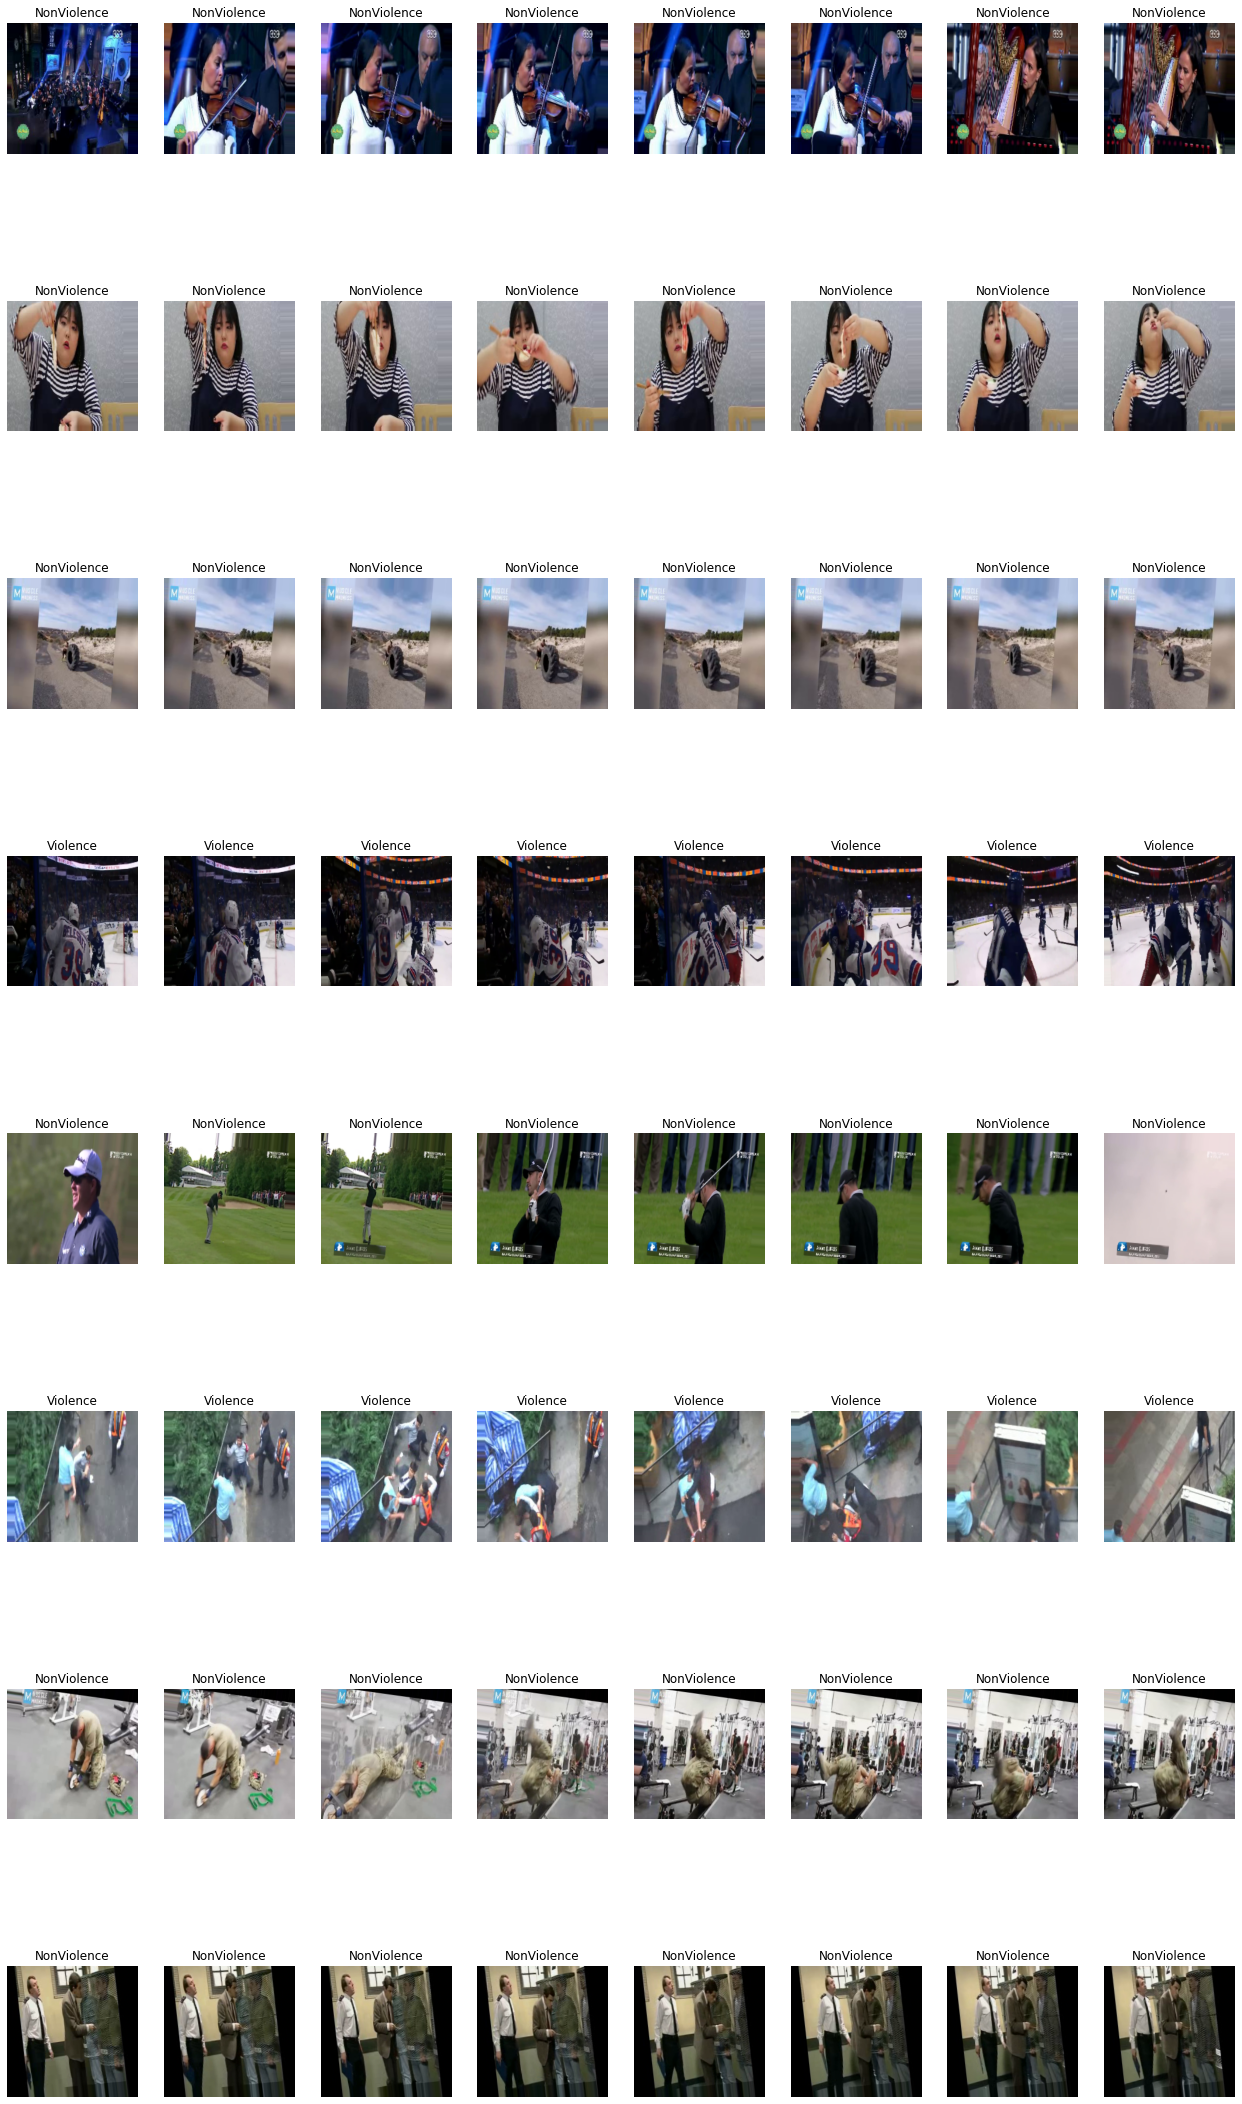

In [7]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [0]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
import keras

In [0]:
def build_mobilenet(shape=(224, 224, 3), nbout=2):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    # Keep 9 layers to train﻿﻿
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [0]:
def action_model(shape=(8, 112, 112, 3), nbout=2):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_mobilenet(shape[1:], nbout = 2)
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape = shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model
    # ...

In [0]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 224, 224, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.SGD()
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [0]:
!mkdir chkp
EPOCHS=50
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

mkdir: cannot create directory ‘chkp’: File exists
Epoch 1/50
102/225 [============>.................] - ETA: 5:06 - loss: 0.6874 - acc: 0.5453

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 193 could not be retrieved. It could be because a worker has died.
  UserWarning)


225/225 [==============================] - 651s 3s/step - loss: 0.6731 - acc: 0.5878 - val_loss: 0.6935 - val_acc: 0.7350

Epoch 00001: saving model to chkp/weights.01-0.69.hdf5
Epoch 2/50
225/225 [==============================] - 135s 601ms/step - loss: 0.5394 - acc: 0.7361 - val_loss: 0.2026 - val_acc: 0.8400

Epoch 00002: saving model to chkp/weights.02-0.20.hdf5
Epoch 3/50
225/225 [==============================] - 140s 621ms/step - loss: 0.4368 - acc: 0.8017 - val_loss: 0.1981 - val_acc: 0.9150

Epoch 00003: saving model to chkp/weights.03-0.20.hdf5
Epoch 4/50
225/225 [==============================] - 140s 620ms/step - loss: 0.3239 - acc: 0.8694 - val_loss: 0.2517 - val_acc: 0.9000

Epoch 00004: saving model to chkp/weights.04-0.25.hdf5
Epoch 5/50
225/225 [==============================] - 141s 629ms/step - loss: 0.2952 - acc: 0.8733 - val_loss: 0.1764 - val_acc: 0.8900

Epoch 00005: saving model to chkp/weights.05-0.18.hdf5
Epoch 6/50
225/225 [==============================] - 